In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [21]:
data = pd.read_csv('data/final_cleaned.csv', dtype={1: str})

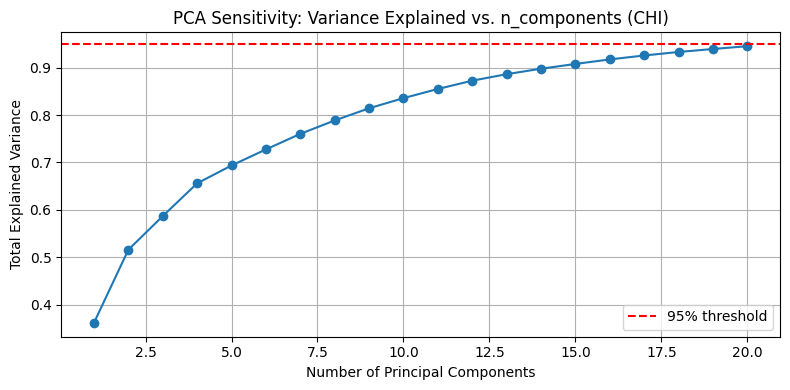

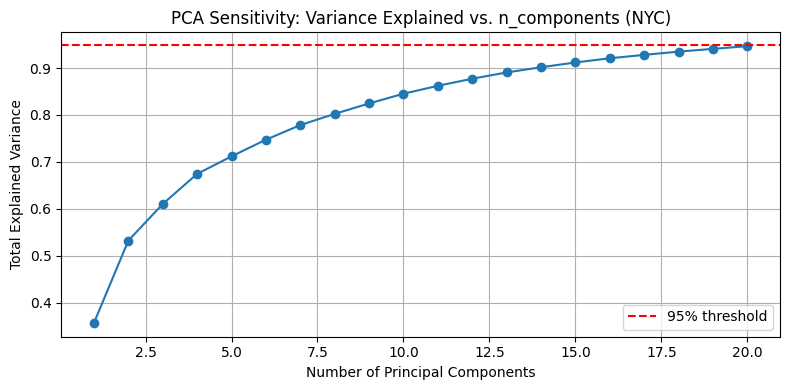

In [51]:
n_components = 20
states = ['CHI', 'NYC']
results = {}
component_range = list(range(1, n_components + 1))

for state in states:

    # Prepare and group data
    df_state = data[data['state'] == state].copy().dropna().reset_index(drop=True)
    df_state['snow_any'] = (df_state['snowfall_sum'] > 0).astype(int)
    df_state['snow_heavy'] = (df_state['snowfall_sum'] > 1.0).astype(int)
    df_state = df_state.drop(columns=['unit_id', 'snowfall_sum', 'snowfall_max'])
    df_state = df_state.groupby(['date', 'mode']).mean(numeric_only=True).reset_index()


    exclude_cols = ['date', 'state', 'daily_ridership']
    feature_cols = [col for col in df_state.columns if col not in exclude_cols]

    # One-hot encode mode
    mode_dummies = pd.get_dummies(df_state['mode'], prefix='mode', drop_first=True)

    # Select columns to scale 
    possible_binary_cols = ['is_weekend', 'is_holiday', 'is_holiday_adj', 'snow_any', 'snow_heavy']
    binary_cols = [col for col in possible_binary_cols if col in df_state.columns]
    to_scale = [col for col in feature_cols if col not in binary_cols + ['mode']]

    # Standardize continuous variables
    scaler = StandardScaler()
    X_scaled_part = scaler.fit_transform(df_state[to_scale])
    scaled_df = pd.DataFrame(X_scaled_part, index=df_state.index, columns=to_scale)

    # Combine Everything
    for col in binary_cols:
        scaled_df[col] = df_state[col].values    
    X_final = pd.concat([mode_dummies.reset_index(drop=True), scaled_df], axis=1)

    # Explained variance curve
    explained_var_curve = []
    for n in component_range:
        pca = PCA(n_components=n, random_state=27)
        pca.fit(X_final)
        explained_var_curve.append(pca.explained_variance_ratio_.sum())
        
    plt.figure(figsize=(8, 4))
    plt.plot(component_range, explained_var_curve, marker='o')
    plt.axhline(y=0.95, linestyle='--', color='r', label='95% threshold')
    plt.title(f"PCA Sensitivity: Variance Explained vs. n_components ({state})")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Total Explained Variance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Full PCA
    pca = PCA(n_components=n_components, random_state=27)
    X_pca = pca.fit_transform(X_final)

    

    explained_var = pd.DataFrame({
        'Component': [f'PC{i+1}' for i in range(pca.n_components_)],
        'Explained Variance Ratio': pca.explained_variance_ratio_
    })

    loadings = pd.DataFrame(
        pca.components_.T,
        index=X_final.columns,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)]
    )

    results[state] = {
        'X_pca': X_pca,
        'explained_var': explained_var,
        'loadings': loadings,
        'features': X_final,
        'sensitivity': explained_var_curve
    }

    # Export feature matrix
    X_final_comp = pd.concat([df_state[['date', 'mode', 'daily_ridership']], mode_dummies.reset_index(drop=True), scaled_df], axis=1)
    X_final_comp.to_csv(f"data/{state}_trunc.csv", index=False)


In [36]:
results['NYC']['explained_var'].head(10)

,Component,Explained Variance Ratio
0,PC1,0.330552
1,PC2,0.162584
2,PC3,0.072552
3,PC4,0.061551
4,PC5,0.037919
5,PC6,0.035381
6,PC7,0.032794
7,PC8,0.030818
8,PC9,0.028633
9,PC10,0.021907


In [38]:
results['CHI']['explained_var'].head(10)

,Component,Explained Variance Ratio
0,PC1,0.335681
1,PC2,0.143178
2,PC3,0.067895
3,PC4,0.065931
4,PC5,0.037102
5,PC6,0.034798
6,PC7,0.031983
7,PC8,0.030117
8,PC9,0.028740
9,PC10,0.026051


In [40]:
pcs = ['PC1', 'PC2', 'PC3', 'PC4']
states = ['CHI', 'NYC']

for state in states:
    print([feat for feat in results[state]['loadings'].index if 'mode_' in feat])
    for pc in pcs:
        print(state,pc)
        loadings = results[state]['loadings'][pc]
        top_features = loadings.abs().sort_values(ascending=False).head(20)
        print(top_features)

['mode_train']
CHI PC1
us_aqi_mean                 0.231962
us_aqi_pm2_5_mean           0.225131
us_aqi_pm10_mean            0.223992
us_aqi_min                  0.221729
us_aqi_pm2_5_min            0.220543
us_aqi_pm10_min             0.219898
us_aqi_pm10_max             0.217102
us_aqi_pm2_5_max            0.217054
us_aqi_max                  0.215147
us_aqi_max_bin              0.203752
us_aqi_mean_bin             0.199971
us_aqi_mean_lag             0.199228
us_aqi_min_lag              0.194924
us_aqi_min_bin              0.189798
us_aqi_max_lag              0.188483
us_aqi_max_bin_lag          0.177838
us_aqi_mean_bin_lag         0.173222
us_aqi_min_bin_lag          0.170952
us_aqi_ozone_max            0.155374
apparent_temperature_max    0.146723
Name: PC1, dtype: float64
CHI PC2
us_aqi_nitrogen_dioxide_mean    0.300777
us_aqi_ozone_min                0.294893
us_aqi_nitrogen_dioxide_min     0.284987
us_aqi_ozone_mean               0.268336
us_aqi_sulphur_dioxide_mean     0.24462

In [47]:
X_final_comp.head()

,date,daily_ridership,mode_subway,rain_sum,rain_max,relative_humidity_2m_min,relative_humidity_2m_max,relative_humidity_2m_mean,apparent_temperature_min,apparent_temperature_max,...,us_aqi_max_bin_lag,us_aqi_max_lag,us_aqi_mean_bin,us_aqi_mean_bin_lag,us_aqi_mean_lag,is_holiday_adjacent,is_weekend,is_holiday,snow_any,snow_heavy
0,2023-01-01,1138.528967,False,-0.055314,-0.044939,-0.005741,1.274998,0.875430,-0.149096,-0.564355,...,1.430683,0.961783,0.71944,0.717293,1.896281,3.148086,1.0,1.0,0.0,0.0
1,2023-01-01,3929.710280,True,-0.055314,-0.044939,-0.005741,1.274998,0.875430,-0.149096,-0.564355,...,1.430683,0.961783,0.71944,0.717293,1.896281,3.148086,1.0,1.0,0.0,0.0
2,2023-01-02,1803.312343,False,-0.303307,-0.238592,0.237532,0.228408,0.217885,-0.403263,-0.516413,...,0.050961,0.331006,0.71944,0.717293,0.700501,3.148086,0.0,1.0,0.0,0.0
3,2023-01-02,4581.294393,True,-0.303307,-0.238592,0.237532,0.228408,0.217885,-0.403263,-0.516413,...,0.050961,0.331006,0.71944,0.717293,0.700501,3.148086,0.0,1.0,0.0,0.0
4,2023-01-03,3074.851385,False,-0.258217,-0.168173,1.514716,1.274998,1.638075,-0.118282,-0.529828,...,0.050961,0.522851,2.53920,0.717293,0.438041,3.148086,0.0,0.0,0.0,0.0
